In [283]:
import glob
import shutil
import numpy as np
import pandas as pd
from biom import load_table
from skbio.stats.composition import clr_inv as softmax
from skbio.util import get_data_path
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.spatial.distance import pdist
from mmvec.multimodal import MMvec
from mmvec.util import random_multimodal
from tensorflow import set_random_seed
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import clr

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

%matplotlib inline

In [284]:
def mmvec_fit(trainX, trainY, testX, testY):
    device_name='/device:GPU:0'
    np.random.seed(2)
    tf.reset_default_graph()
    n, d1 = trainX.shape
    n, d2 = trainY.shape
    with tf.Graph().as_default(), tf.Session() as session:
        set_random_seed(0)
        model = MMvec(beta_1=0.8, beta_2=0.9, latent_dim=3, 
                      device_name=device_name, batch_size=10000, 
                      learning_rate=1e-1)
        model(session,
              coo_matrix(trainX.values), trainY.values,
              coo_matrix(testX.values), testY.values)
        loss, cv = model.fit(epoch=1000)

        res = softmax(model.ranks())
        return res

# Dense benchmark configurations

In [285]:
metabolite_total = 100000
microbe_total = 10000

In [286]:
sigmaB = 1.418    
sigmaQ = 0.8735   
sigmaU = 0.1      
sigmaV = 0.1      
uB = -3.0    
uU = -3.0      
uV = -0.6325

In [287]:
np.random.seed(1)
res = random_multimodal(
    num_microbes=100, num_metabolites=100, num_samples=500,
    latent_dim=3, sigmaQ=sigmaQ, uU=uU, uV=uV, sigmaU=sigmaU, sigmaV=sigmaV,
    microbe_total=microbe_total, metabolite_total=metabolite_total, seed=1
)
(microbes, metabolites, X, B,
 U, Ubias, V, Vbias) = res
num_train = 10
trainX = microbes.iloc[:-num_train]
testX = microbes.iloc[-num_train:]
trainY = metabolites.iloc[:-num_train]
testY = metabolites.iloc[-num_train:]

In [288]:
(microbes == 0).sum().sum() / (microbes.shape[0] * microbes.shape[1])

0.0001

In [289]:
C = np.corrcoef(microbes.values.T, metabolites.values.T) 
Cclr = np.corrcoef(clr(microbes.values+1).T, clr(metabolites.values+1).T)

In [290]:
res = mmvec_fit(trainX, trainY, testX, testY)
U_ = np.hstack(
    (np.ones((U.shape[0], 1)), Ubias, U))
V_ = np.vstack(
    (Vbias, np.ones((1, V.shape[1])), V))
exp = softmax(np.hstack((np.zeros((microbes.shape[1], 1)), U_ @ V_)))
mmvec_r, mmvec_p = spearmanr(np.ravel(res), np.ravel(exp))

cidx = ~np.isnan(C[:100, 100:])
C_ = C[:100, 100:]

clr_idx = ~np.isnan(Cclr[:100, 100:])
Cclr_ = Cclr[:100, 100:]
C_r, C_p = spearmanr(np.ravel(C_[cidx]), np.ravel(exp[cidx]))
Cclr_r, Cclr_p = spearmanr(np.ravel(Cclr_[clr_idx]), np.ravel(exp[clr_idx]))
print(C_r, C_p, Cclr_r, Cclr_p)

100%|██████████| 4899/4899 [00:25<00:00, 195.72it/s]

0.0015118636351186365 0.8798435470356817 0.0036123583201235834 0.7179560318111802


In [ ]:
title_font = 14

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(np.log(np.ravel(res)), np.log(np.ravel(exp)), s=.1)
s_r, s_p = pearsonr(np.ravel(res), np.ravel(exp))
ax[0].set_title('MMvec \n (R={0:.3f}, p={1:.3f})'.format(s_r, s_p), fontsize=title_font)
ax[0].set_xlabel('Estimated co-occurrences', fontsize=title_font)
ax[0].set_ylabel('Ground truth \n co-occurrences', fontsize=title_font)

ax[1].scatter(np.log(np.ravel(C_[cidx])), np.log(np.ravel(exp[cidx])), s=.1)
s_r, s_p = pearsonr(np.ravel(C_[cidx]), np.ravel(exp[cidx]))
ax[1].set_title('Pearson\n(R={0:.3f}, p={1:.3f})'.format(s_r, s_p), fontsize=title_font)
ax[1].set_xlabel('Estimated co-occurrences', fontsize=title_font)
#ax[2].ylabel('Ground truth co-occurrences')

ax[2].scatter(np.log(np.ravel(Cclr_[clr_idx])), np.log(np.ravel(exp[clr_idx])), s=.1)
s_r, s_p = pearsonr(np.ravel(Cclr_[clr_idx]), np.ravel(exp[clr_idx]))
ax[2].set_title('CLR transformed Pearson \n (R={0:.3f}, p={1:.3f})'.format(s_r, s_p), 
                fontsize=title_font)
ax[2].set_xlabel('Estimated co-occurrences', fontsize=title_font)
#ax[1].set_ylabel('Ground truth co-occurrences')

plt.tight_layout()
plt.savefig('../results/dense_benchmark.png')

# Sparse benchmark configurations

In [296]:
sigmaB = 10.0     
sigmaQ = 10.0     
sigmaU = 0.1      
sigmaV = 10.0     
uB = -5.0      
uU = 0.135    
uV = -0.07268

In [297]:
np.random.seed(1)
res = random_multimodal(
    num_microbes=100, num_metabolites=100, num_samples=500,
    latent_dim=3, sigmaQ=sigmaQ, uU=uU, uV=uV, sigmaU=sigmaU, sigmaV=sigmaV,
    microbe_total=microbe_total, metabolite_total=metabolite_total, seed=1
)
(microbes, metabolites, X, B,
 U, Ubias, V, Vbias) = res
num_train = 10
trainX = microbes.iloc[:-num_train]
testX = microbes.iloc[-num_train:]
trainY = metabolites.iloc[:-num_train]
testY = metabolites.iloc[-num_train:]

In [298]:
(microbes == 0).sum().sum() / (microbes.shape[0] * microbes.shape[1])

0.39828

In [299]:
C = np.corrcoef(microbes.values.T, metabolites.values.T) 
Cclr = np.corrcoef(clr(microbes.values+1).T, clr(metabolites.values+1).T)

In [300]:
res = mmvec_fit(trainX, trainY, testX, testY)
U_ = np.hstack(
    (np.ones((U.shape[0], 1)), Ubias, U))
V_ = np.vstack(
    (Vbias, np.ones((1, V.shape[1])), V))
exp = softmax(np.hstack((np.zeros((microbes.shape[1], 1)), U_ @ V_)))
mmvec_r, mmvec_p = spearmanr(np.ravel(res), np.ravel(exp))

cidx = ~np.isnan(C[:100, 100:])
C_ = C[:100, 100:]

clr_idx = ~np.isnan(Cclr[:100, 100:])
Cclr_ = Cclr[:100, 100:]
C_r, C_p = spearmanr(np.ravel(C_[cidx]), np.ravel(exp[cidx]))
Cclr_r, Cclr_p = spearmanr(np.ravel(Cclr_[clr_idx]), np.ravel(exp[clr_idx]))
print(C_r, C_p, Cclr_r, Cclr_p)

100%|██████████| 2953/2953 [00:13<00:00, 211.06it/s]

-0.019602897552816956 0.28311384507420806 -0.1595761262852689 4.9749826797745765e-58


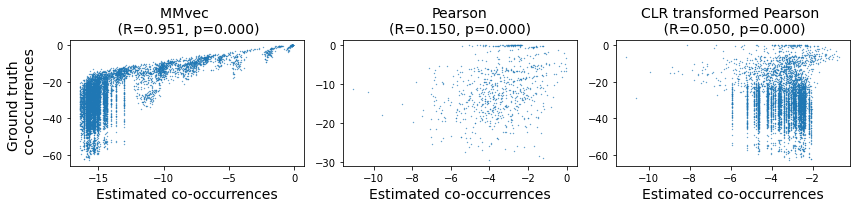

In [301]:
title_font = 14

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(np.log(np.ravel(res)), np.log(np.ravel(exp)), s=.1)
s_r, s_p = pearsonr(np.ravel(res), np.ravel(exp))
ax[0].set_title('MMvec \n (R={0:.3f}, p={1:.3f})'.format(s_r, s_p), fontsize=title_font)
ax[0].set_xlabel('Estimated co-occurrences', fontsize=title_font)
ax[0].set_ylabel('Ground truth \n co-occurrences', fontsize=title_font)

ax[1].scatter(np.log(np.ravel(C_[cidx])), np.log(np.ravel(exp[cidx])), s=.1)
s_r, s_p = pearsonr(np.ravel(C_[cidx]), np.ravel(exp[cidx]))
ax[1].set_title('Pearson\n(R={0:.3f}, p={1:.3f})'.format(s_r, s_p), fontsize=title_font)
ax[1].set_xlabel('Estimated co-occurrences', fontsize=title_font)
#ax[2].ylabel('Ground truth co-occurrences')

ax[2].scatter(np.log(np.ravel(Cclr_[clr_idx])), np.log(np.ravel(exp[clr_idx])), s=.1)
s_r, s_p = pearsonr(np.ravel(Cclr_[clr_idx]), np.ravel(exp[clr_idx]))
ax[2].set_title('CLR transformed Pearson \n (R={0:.3f}, p={1:.3f})'.format(s_r, s_p), 
                fontsize=title_font)
ax[2].set_xlabel('Estimated co-occurrences', fontsize=title_font)
#ax[1].set_ylabel('Ground truth co-occurrences')

plt.tight_layout()
plt.savefig('../results/sparse_benchmark.png')